In [2]:
import sys
sys.path.append('..')

import torch
import pickle
import argparse
import yaml
import numpy as np


from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models_yield import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test, evaluate1
from collections import namedtuple


def prune_dataset_by_length(dataset, max_len):
    new_dataset = {}
    for idx in dataset:
        r_mask = dataset[idx]['reactants']['mask']
        r_mask = r_mask[r_mask > 0]
        if len(dataset[idx]['target_main_product']) <= max_len and len(np.unique(r_mask)) == len(r_mask):
            new_dataset[idx] = dataset[idx]
    return new_dataset

def delete_idx(dataset):
    new_dataset = {}
    for idx in dataset:
        if dataset[idx]['mined yield'] <= 1:
            new_dataset[idx] = dataset[idx]
    return new_dataset


def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)


def main(config, device):
    model_cfg = convert(config["model"])
    data_cfg = convert(config["dataset"])
    train_cfg = convert(config["train"])
    paths = convert(config["paths"])

    meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

    node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                           n_reaction_level=data_cfg.n_reaction_level)
    bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                           n_reaction_level=data_cfg.n_reaction_level,
                           self_bond=data_cfg.self_bond)
    if data_cfg.same_bond:
        bond2label = {i: 0 if i in meta['type'] else bond2label[i] for i in bond2label}
    num_rels = len(bond2label)
    pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
                 data_cfg.n_molecule_level * data_cfg.n_reaction_level
    num_nodes = pad_length

    model = RGCNNTrClassifier([len(node2label)] + data_cfg.feature_sizes,
                              num_nodes,
                              train_cfg.batch_size,
                              [model_cfg.n_hidden] + [model_cfg.feature_embed_size] * len(data_cfg.feature_sizes),
                              num_rels,
                              model_cfg.num_conv_layers,
                              model_cfg.num_trans_layers,
                              model_cfg.num_fcn_layers,
                              model_cfg.num_attention_heads,
                              model_cfg.num_model_heads,
                              )
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=train_cfg.lr, betas=(0.9, 0.98), eps=1e-9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=train_cfg.exp_step_size, gamma=0.1)

    train_dataset = pickle.load(open(paths.dataset_path + 'train.pkl', 'rb'))
    test_dataset = pickle.load(open(paths.dataset_path + 'test.pkl', 'rb'))
    valid_dataset = pickle.load(open(paths.dataset_path + 'valid.pkl', 'rb'))

    train_dataset = prune_dataset_by_length(train_dataset, data_cfg.max_num_atoms)
    test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
    valid_dataset = prune_dataset_by_length(valid_dataset, data_cfg.max_num_atoms)
    
    train_dataset = delete_idx(train_dataset)
    test_dataset = delete_idx(test_dataset)
    valid_dataset = delete_idx(valid_dataset)

    tr_dataset = Dataset(train_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
    ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
    vl_dataset = Dataset(valid_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)

    train_loader = DataLoader(tr_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)
    test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)
    valid_loader = DataLoader(vl_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

    valid_scores = []
    test_scores = []
    valid_scores_1 = []
    test_scores_1 = []
    losses = []
    print('Training is starting')
    for epoch in range(30):
        losses.append(train_epoch(model, train_loader, optimizer, exp_lr_scheduler))
        loss = np.array(losses[-1])
        score_v = evaluate(model, valid_loader)
        score_t = evaluate(model, test_loader)
        score_v_1 = evaluate1(model, valid_loader)
        score_t_1 = evaluate1(model, test_loader)
        valid_scores.append(score_v)
        test_scores.append(score_t)
        valid_scores_1.append(score_v)
        test_scores_1.append(score_t)
        print(f'Epoch number - {epoch},loss = {loss.mean()}, R2_v = {score_v}, R2_t = {score_t}, L1_v = {score_v_1}, L1_t = {score_t_1}')
    results = test(model, train_loader)
    return losses, results, valid_scores, test_scores, valid_scores_1, test_scores_1

In [2]:
with open('../scripts/graph_models/MP_EG.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [3]:
losses_EG, results_EG, valid_scores_EG, test_scores_EG, valid_scores_1_EG, test_scores_1_EG = main(config, 'cuda:1')

Training is starting
Epoch number - 0,loss = 0.06567938969750807, R2_v = -0.02521751571298081, R2_t = -0.014286729258699227, L1_v = 0.21517521142959595, L1_t = 0.2171255648136139
Epoch number - 1,loss = 0.05787688773833102, R2_v = 0.0628125844749351, R2_t = 0.06849051816781937, L1_v = 0.201982781291008, L1_t = 0.20414140820503235
Epoch number - 2,loss = 0.057296283319479245, R2_v = 0.09319560759704504, R2_t = 0.10233917597516262, L1_v = 0.19512544572353363, L1_t = 0.19683565199375153
Epoch number - 3,loss = 0.05697101486795851, R2_v = 0.09514555002175107, R2_t = 0.10501545665530743, L1_v = 0.19498498737812042, L1_t = 0.1966177523136139
Epoch number - 4,loss = 0.05654917334243202, R2_v = 0.0985062070834688, R2_t = 0.10808804749342138, L1_v = 0.19507570564746857, L1_t = 0.19668470323085785
Epoch number - 5,loss = 0.05636191989315, R2_v = 0.09140718875254927, R2_t = 0.10070474778356076, L1_v = 0.19625180959701538, L1_t = 0.19792062044143677
Epoch number - 6,loss = 0.05619531167716377, R2_

In [3]:
with open('../scripts/graph_models/MP_BASE.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [4]:
losses_B, results_B, valid_scores_B, test_scores_B, valid_scores_1_B, test_scores_1_B = main(config, 'cuda:1')

Training is starting
Epoch number - 0,loss = 0.06261555796438166, R2_v = 0.04092181768729086, R2_t = 0.05248384261707684, L1_v = 0.2054445445537567, L1_t = 0.20706753432750702
Epoch number - 1,loss = 0.057902495375350346, R2_v = 0.08237001201504313, R2_t = 0.09941594636348527, L1_v = 0.19588182866573334, L1_t = 0.19687286019325256


KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

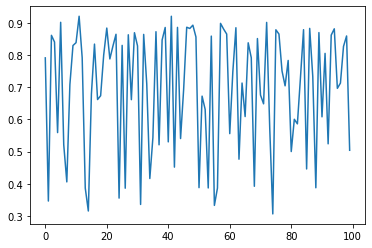

In [49]:
plt.plot(results['predicted'][:100])

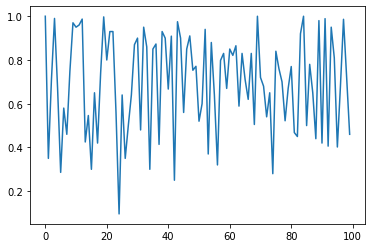

In [50]:
plt.plot(results['target'][:100])

In [41]:
from sklearn.metrics import r2_score
r2_score(results['target'], results['predicted'])

0.3689876209787334

In [42]:
predict = np.mean(np.abs(np.array(results['target']) - np.array(results['predicted'])))

In [43]:
constant = np.mean(np.abs(np.array(results['target']) - np.mean(np.array(results['target']))))

In [44]:
predict, constant

(0.1550707, 0.21061003)

In [22]:
max(results['predicted'])

NameError: name 'results' is not defined

In [27]:
with open('../scripts/graph_models/MP_BASE.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [31]:
losses_base, results_base, valid_scores_base, test_score_base = main(config, 'cuda:1')

Training is starting


KeyboardInterrupt: 

In [10]:
a = np.array([1, 2, 3])
v = a.mean()

In [11]:
v

2.0